# LAB 01: MỐI QUAN HỆ CỦA DỮ LIỆU

## 1. Thông tin nhóm

| MSSV     | HỌ VÀ TÊN          |
|:--------:|:-------------------|
| 20127323 | Võ Nhật Tân        |
| 20127447 | Ngô Đức Bảo        |
| 20127275 | Lê Nguyễn Nhật Phú |
| 20127681 | Nguyễn Thiên Phúc  |


## 2. Lấy thông tin từ website

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime, timedelta
from bs4 import BeautifulSoup

np.set_printoptions(formatter=dict(float='{:0.2f}'.format))

In [2]:
def pre_process_html(table_html):
    table_html = table_html.replace('>N/A<', '>-<')
    
    table = BeautifulSoup(table_html)

    def show_data_continent(tag):
        if tag.name == 'th':
            return True
        
        return 'data-continent' in tag.attrs and tag.name in ['td', 'th'] and tag['data-continent'] != ""

    for k, th in enumerate(table.find_all(show_data_continent)):
        raw_s = th.text
        th['style'] = "color: yellow"


    for k, th in enumerate(table.find_all('th')):
        th.string = th.text

    return table.prettify()

In [3]:
driver = webdriver.Chrome()
driver.maximize_window()

driver.get("https://www.worldometers.info/coronavirus/#main_table")
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "main_table_countries_today")))

#Get updated date
updated_date = driver.find_element(By.CSS_SELECTOR, 'div#page-top+div')
today = datetime.strptime(updated_date.text, "Last updated: %B %d, %Y, %H:%M %Z")

#Get today data
table_element_today = driver.find_element(By.ID, 'main_table_countries_today')
table_html_today = table_element_today.get_attribute('outerHTML')

#Get yesterday data
driver.find_element(By.ID, 'nav-yesterday-tab').click()
table_element_yesterday = driver.find_element(By.ID, 'main_table_countries_yesterday')
table_html_yesterday = table_element_yesterday.get_attribute('outerHTML')

#Get 2-day ago data
driver.find_element(By.ID, 'nav-yesterday2-tab').click()
table_element_yesterday = driver.find_element(By.ID, 'main_table_countries_yesterday2')
table_html_yesterday2 = table_element_yesterday.get_attribute('outerHTML')

driver.quit()

In [4]:
table_html = pre_process_html('\n'.join([table_html_today, table_html_yesterday, table_html_yesterday2]))
df_list = pd.read_html(table_html, keep_default_na=False)

for day in range(3):
    exp_day = today - timedelta(days=day)
    df_list[day].to_csv(f'./raw_data/{exp_day.strftime("%d-%m-%Y")+"_raw"}.csv', index=False, encoding='UTF-8')

## Tiền xử lý dữ liệu

In [5]:
from os import listdir

In [6]:
def pre_process_file(file_path):
    df = pd.read_csv(file_path)

    #Rename the abnormal column's name
    df.rename(columns={'Tot\xa0Cases/1M pop': 'Tot Cases/1M pop'}, inplace=True)

    #Drop the unnecessary columns
    df.drop(columns=['#', 'Serious,Critical'], inplace=True)

    #Drop the total row
    df = df.drop(labels=[len(df) - 1]).reset_index(drop=True)
    
    #Fill the null value with 0 and replace the NA (-) values by np.nan
    df.fillna(0, inplace=True)
    df.replace(to_replace='-', value=np.nan, inplace=True)

    #Change the type of columns
    columns_name = df.select_dtypes(include='object').columns
    for column_name in columns_name:
        if column_name in ['Country,Other', 'Continent'] : continue
        df[column_name] = df[column_name].astype('float')

    #Check if the data has inconsistent values
    sub_df = df.iloc[1:-1, :]

    cal_tot = round(sub_df['TotalCases'] / sub_df['Population'] * 10**6).replace([np.inf, -np.inf], 0)
    cal_deaths = round(sub_df['TotalDeaths'] / sub_df['Population'] * 10**6).replace([np.inf, -np.inf], 0)

    if not np.all(sub_df['Tot Cases/1M pop'] == cal_tot):
        raise Exception(f"Data in the Tot Cases/ 1M pop column is not consistent")
    
    if not np.all(sub_df['Deaths/1M pop'] == cal_deaths):
        raise Exception(f"Data in the Total Deaths column is not consistent")

    return df

In [ ]:
#Apply the preprocess to all the file in raw_data and save them to data folder
files = [f for f in listdir('./raw_data/')]

for file in files:
    url = './raw_data/' + file
    print(url)
    df = pre_process_file(url)
    df.to_csv('./data/' + file.replace('_raw', ''), index=False, encoding='UTF-8')

## Trực quan hóa dữ liệu

In [103]:
def concatinate_data(list_file_name, folder_path = './data/'):
    df = pd.DataFrame()

    for file_name in list_file_name:
        df_cat = pd.read_csv(folder_path + file_name)
        df_cat['DateCollected'] = pd.to_datetime(file_name.replace('.csv', ''), dayfirst=True)

        df = pd.concat([df, df_cat], axis=0)
    df = df.reset_index()
    df = df.drop(columns={'index'})
    return df

In [104]:
from os import listdir

files = [datetime.strptime(f.replace('.csv', ''), '%d-%m-%Y') for f in listdir('./data/')]

three_newest_days = sorted(files)
df = concatinate_data(map(lambda date: date.strftime("%d-%m-%Y") + '.csv', three_newest_days))

In [105]:
days = [f for f in listdir('./data/')]
df = concatinate_data(days)

In [106]:
df.head(5)

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop,Population,Continent,DateCollected
0,World,680261711,143685.0,6802334.0,767.0,653004808.0,173193.0,20454569.0,87271.0,872.7,0.000000e+00,0.0,0.000000e+00,All,2023-03-01
1,USA,105373517,18136.0,1146500.0,207.0,102748085.0,64851.0,1478932.0,314731.0,3424.0,1.167210e+09,3486236.0,3.348053e+08,North America,2023-03-01
2,India,44686879,268.0,530772.0,0.0,44153668.0,164.0,2439.0,31769.0,377.0,9.187944e+08,653188.0,1.406632e+09,Asia,2023-03-01
3,France,39626756,4525.0,164988.0,25.0,39390798.0,3619.0,70970.0,604209.0,2516.0,2.714902e+08,4139547.0,6.558452e+07,Europe,2023-03-01
4,Germany,38189954,21046.0,168175.0,89.0,37715700.0,16500.0,306079.0,455273.0,2005.0,1.223324e+08,1458359.0,8.388360e+07,Europe,2023-03-01


## Tình hình dịch bệnh COVID-19 trên Thế giới trong vòng 10 ngày (26/2/2023 đến ngày 10/3/2023)

In [111]:
world_df = df[df['Country,Other'] == 'World']

### 1. Tổng số ca nhiễm

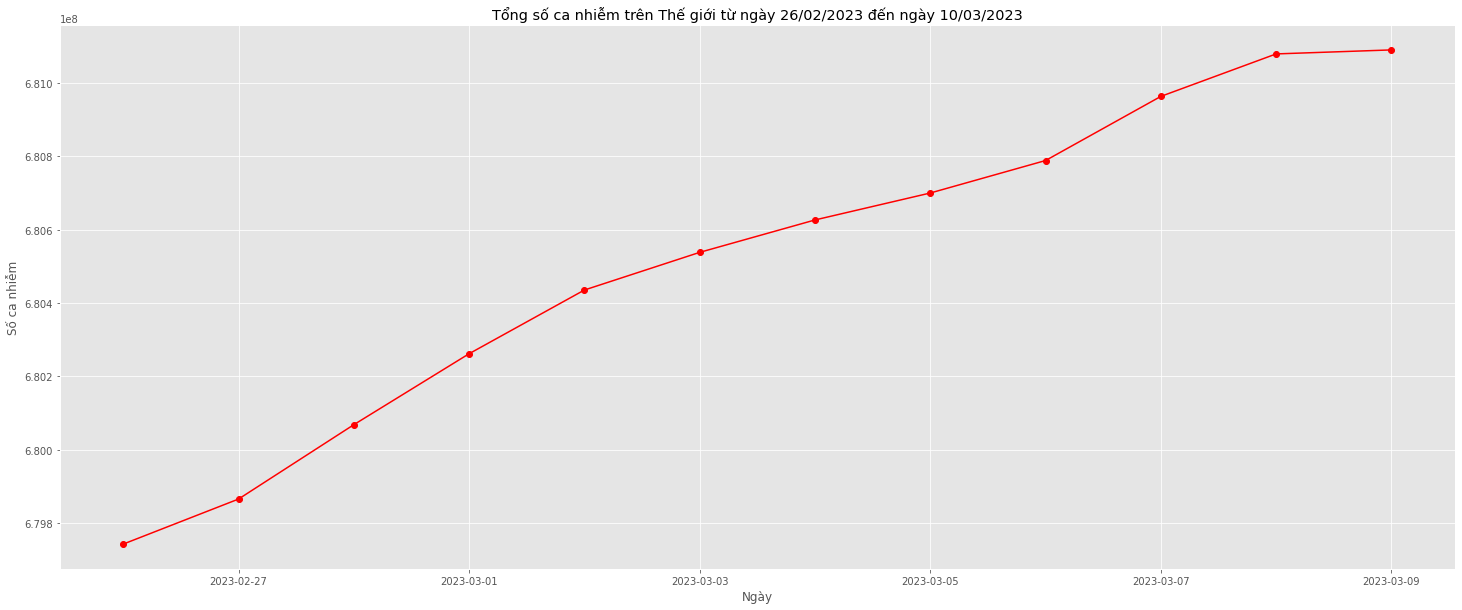

(array([19415.00, 19417.00, 19419.00, 19421.00, 19423.00, 19425.00]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

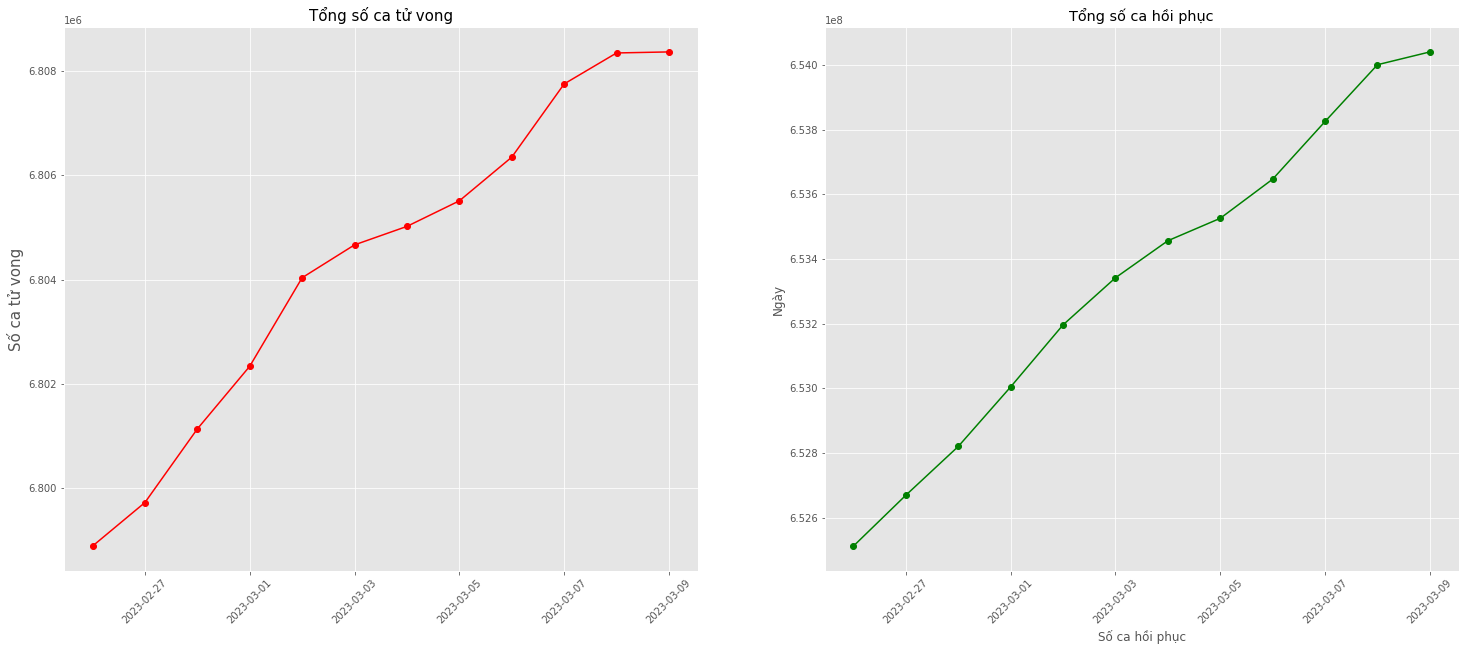

In [112]:
total_cases = world_df.groupby('DateCollected')['TotalCases'].sum()

fig = plt.figure(figsize=(25, 10))

ax1 = fig.add_subplot(111)
ax1.plot(total_cases, label='Total Cases', marker='o', color='red');
ax1.set(xlabel='Ngày', ylabel='Số ca nhiễm', title='Tổng số ca nhiễm trên Thế giới từ ngày 26/02/2023 đến ngày 10/03/2023');
plt.show();

tot_death = world_df.groupby('DateCollected')['TotalDeaths'].sum()
tot_recover = world_df.groupby('DateCollected')['TotalRecovered'].sum()

fig = plt.figure(2)
fig.set_figwidth(25)
fig.set_figheight(10)

ax2 = fig.add_subplot(121)
ax2.plot(tot_death, label='Total Deaths', marker='o', color='red');
ax2.set_ylabel('Số ca tử vong', size = 15)
ax2.set_title('Tổng số ca tử vong', size=15)
plt.xticks(rotation=45)

ax3 = fig.add_subplot(122)
ax3.plot(tot_recover, label='Total Recovered', marker='o', color='green');
ax3.set(xlabel='Số ca hồi phục', ylabel='Ngày', title='Tổng số ca hồi phục')
plt.xticks(rotation=45)

Từ biểu đồ trên, ta thấy rằng tổng số ca nhiễm, số ca hồi phục và số ca tử vong tăng dần từ ngày 26/2/2023 đến ngày 10/3/2023. Điều này cho thấy rằng dịch bệnh đang diễn biến phức tạp và có xu hướng tăng dần.

Tổng số ca tử vong và hồi phục trên thế giới tăng theo từng ngày

### 3. Tổng số test thực hiện trên mỗi châu lục

Vì cột giữ liệu quốc gia có chứa quốc gia World không phải là một quốc gia nên ta sẽ loại bỏ nó ra khỏi dữ liệu.

In [113]:
final_df = df.drop(df[df['Country,Other'] == 'World'].index).reset_index(drop=True)
days = [f.replace('.csv', '') for f in days]

In [114]:
test_df = final_df.groupby('Continent')['Tests/ 1M pop'].sum()
test_df = test_df[test_df != 0]

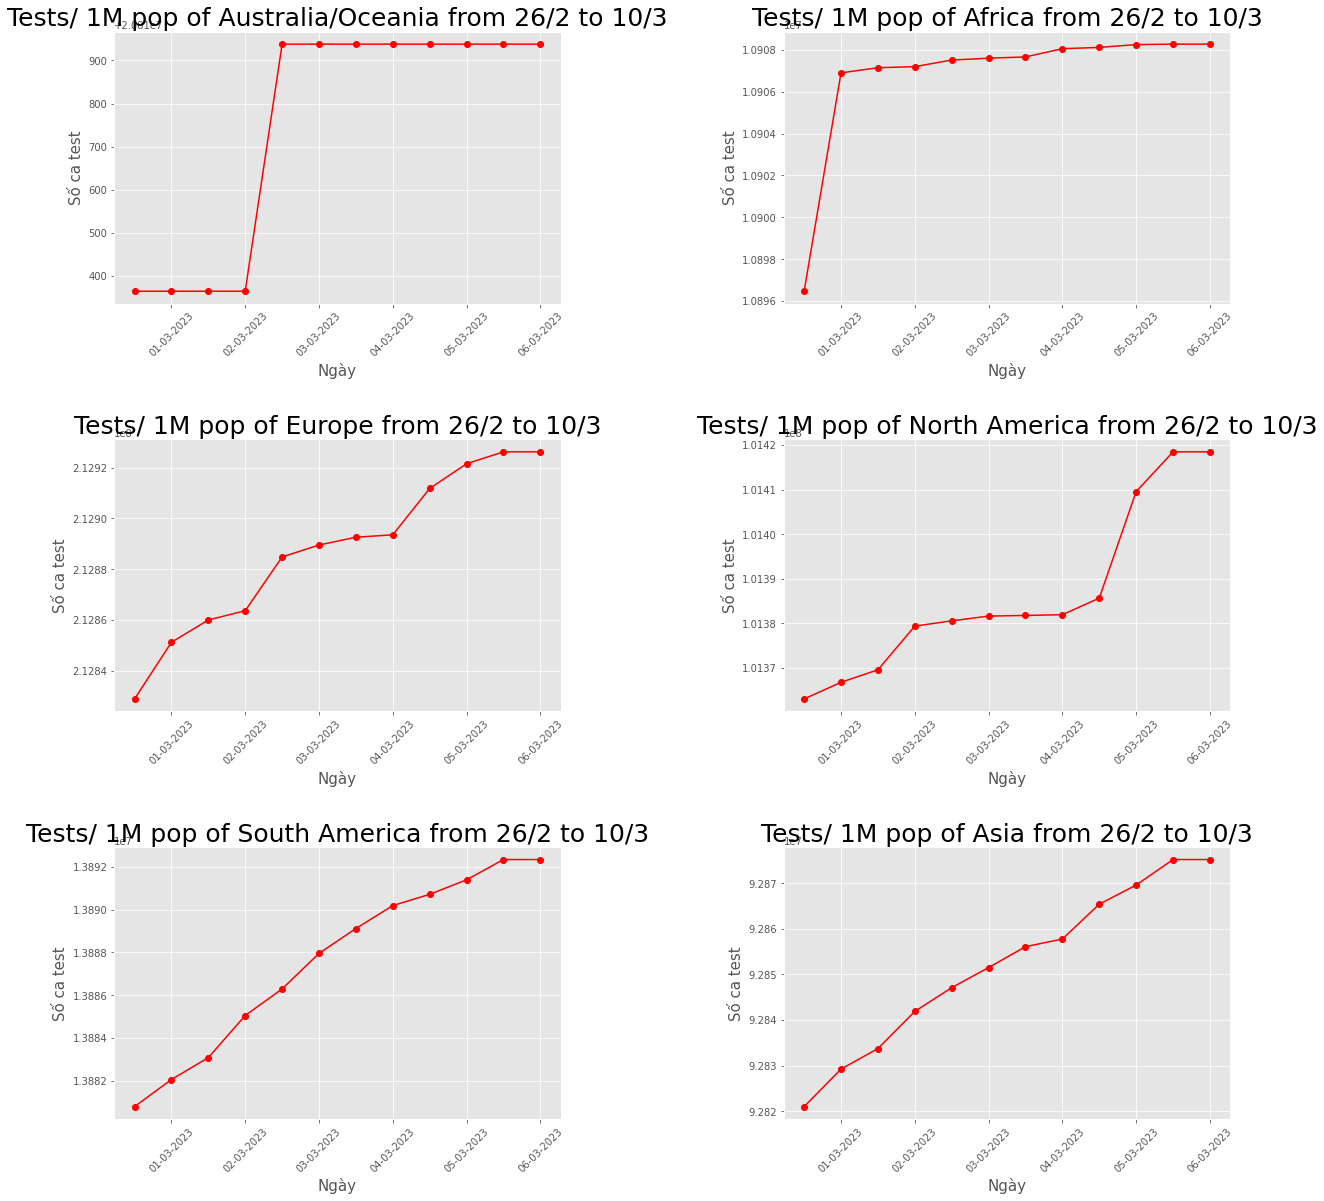

In [115]:
continent_names = final_df.sort_values('TotalCases')['Continent'].unique()
continent_names = continent_names[continent_names != '0']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.set_figheight(20)
fig.set_figwidth(20)

for i, con in enumerate(continent_names):
    ax = axes[i//2, i%2]
    ax.plot(final_df[final_df['Continent'] == con].groupby('DateCollected')['Tests/ 1M pop'].sum(), label='Tests/ 1M pop', marker='o', color='red')
    ax.set_title(f'Tests/ 1M pop of {con} from 26/2 to 10/3', size=25)
    ax.set_ylabel('Số ca test', size = 15)
    ax.set_xlabel('Ngày', size = 15)
    ax.set_xticklabels(days, rotation=45)


Từ biểu đồ thực hiện test của các châu lục, ta nhận xét rằng các châu lục cũng tăng cường việc thực hiện test để phát hiện ra các ca nhiễm.

## Tình hình dịch bệnh Covid-19 trên 5 quốc gia có tỉ lệ ca tử vong cao nhất (xét trên 1 triệu dân)

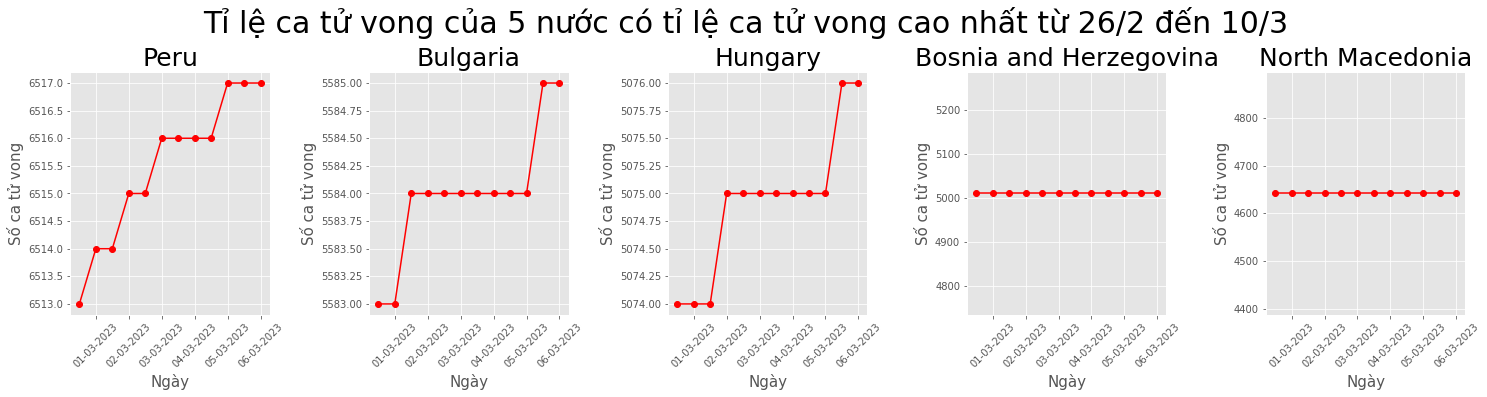

In [116]:
top_5_countries_death = final_df.sort_values('Deaths/1M pop', ascending=False)['Country,Other'].unique()[:5]
top_5_countries_death_df = final_df[final_df['Country,Other'].isin(top_5_countries_death)].loc[:, ['NewCases', 'NewDeaths', 'NewRecovered', 'Country,Other', 'Deaths/1M pop', 'DateCollected']].reset_index(drop=True)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.set_figheight(5)
fig.set_figwidth(25)

for i, country in enumerate(top_5_countries_death):
    ax = axes[i]
    ax.plot(top_5_countries_death_df[top_5_countries_death_df['Country,Other'] == country].groupby('DateCollected')['Deaths/1M pop'].sum(), label='Deaths/1M pop', marker='o', color='red')
    ax.set_title(f'{country}', size=25)
    ax.set_ylabel('Số ca tử vong', size = 15)
    ax.set_xlabel('Ngày', size = 15)
    ax.set_xticklabels(days, rotation=45)

fig.suptitle('Tỉ lệ ca tử vong của 5 nước có tỉ lệ ca tử vong cao nhất từ 26/2 đến 10/3', size=30)
#space between subtitle and plot
fig.subplots_adjust(top=0.8)


Ta cùng tìm hiểu các số liệu về dịch bệnh Covid-19 trên 5 quốc gia có tỉ lệ ca tử vong cao nhất trên 1 triệu dân.

### a. Tỉ lệ ca nhiễm mới (xét trên 1 triệu dân số)

In [117]:
new_cases_df = final_df[final_df['Country,Other'].isin(top_5_countries_death)].loc[:, ['Country,Other', 'NewCases', 'DateCollected', 'Population']].reset_index(drop=True)
new_cases_df['NewCasesPerCapital'] = new_cases_df['NewCases'] / new_cases_df['Population'] * 1000000

Text(0.5, 0.98, 'Tỉ lệ ca nhiễm mới của các nước từ 26/2 đến 10/3')

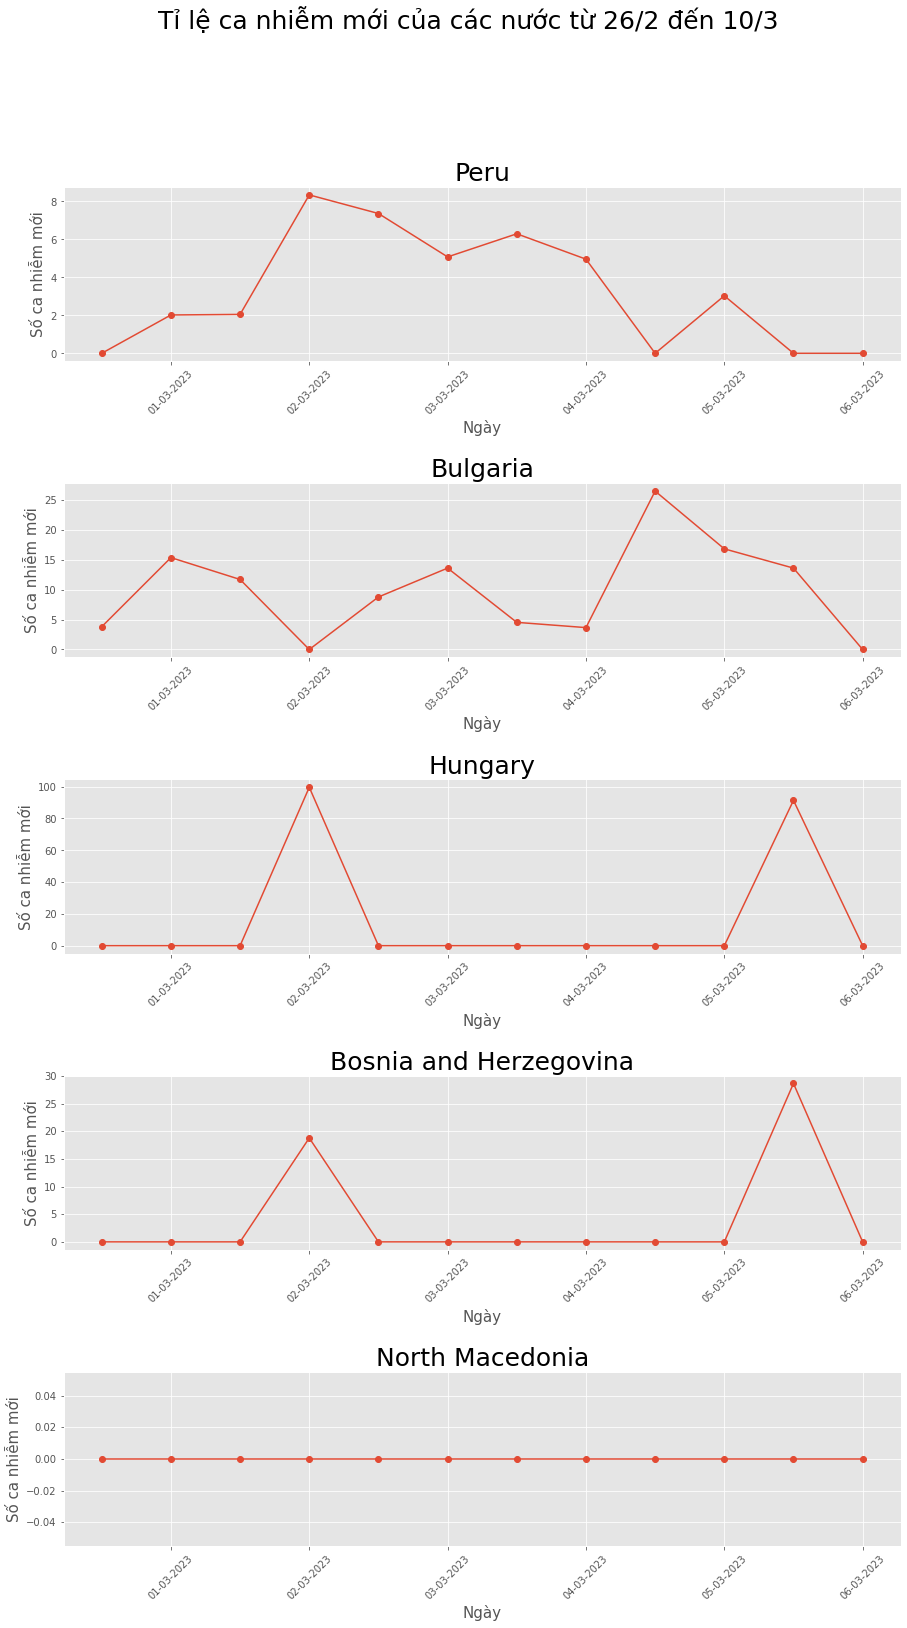

In [155]:
#draw line chart for each country
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(5, 5)
gs.update(wspace=0.7, hspace=0.7)


for i, country in enumerate(top_5_countries_death):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(new_cases_df[new_cases_df['Country,Other'] == country].groupby('DateCollected')['NewCasesPerCapital'].sum(), label='NewCasesPerCapital', marker='o')
    ax.set_title(f'{country}', size=25)
    ax.set_ylabel('Số ca nhiễm mới', size = 15)
    ax.set_xlabel('Ngày', size = 15)
    ax.set_xticklabels(days, rotation=45)
        
plt.suptitle(f'Tỉ lệ ca nhiễm mới của các nước từ 26/2 đến 10/3', size=25)

Từ biểu đồ trên, ta thấy tỉ lệ ca nhiễm mới của các nước (xét trên 1 triệu dân) có xu hướng giảm dần

### b. Tỉ lệ của việc thực hiện test (xét trên 1 triệu dân số)

Ta tính tổng việc thực hiện test đến thời điểm hiện tại, sau đó tính tỉ lệ thực hiện test giữa các nước 

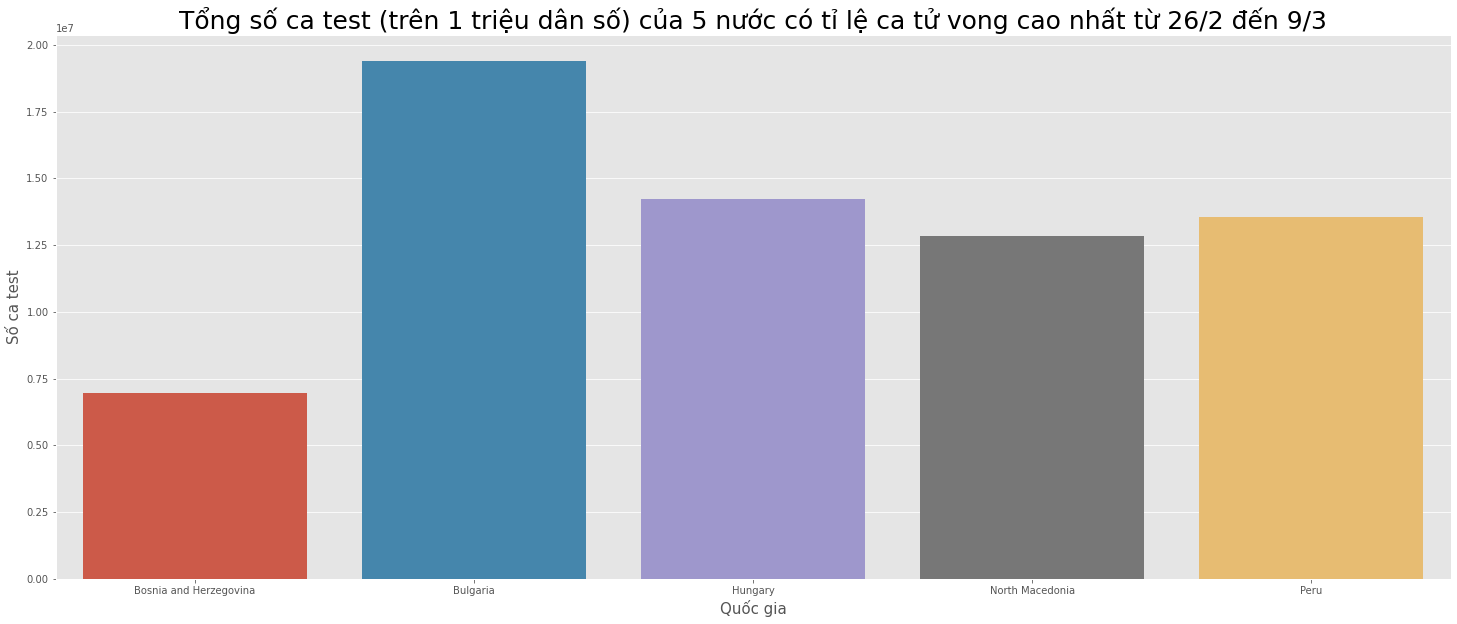

In [120]:
total_tests_df = final_df[final_df['Country,Other'].isin(top_5_countries_death)].loc[:, ['Country,Other', 'Tests/ 1M pop', 'DateCollected', 'Population']].reset_index(drop=True)
#calculate total tests until 8/3
total_tests_df.groupby('Country,Other')['Tests/ 1M pop'].sum()
plt.figure(figsize=(25, 10))
sns.barplot(x=total_tests_df.groupby('Country,Other')['Tests/ 1M pop'].sum().index, y=total_tests_df.groupby('Country,Other')['Tests/ 1M pop'].sum().values)
plt.title('Tổng số ca test (trên 1 triệu dân số) của 5 nước có tỉ lệ ca tử vong cao nhất từ 26/2 đến 9/3', size=25)
plt.ylabel('Số ca test', size = 15)
plt.xlabel('Quốc gia', size = 15)
plt.show()

Từ biểu đồ trên ta thấy, Bulgaria là quốc gia có tỉ lệ thực hiện test cao nhất trong 5 nước có tỉ lệ ca tử vong cao nhất 

### c. Tổng số ca tử vong và số ca nhiễm mới

Text(0.5, 0, 'Ngày')

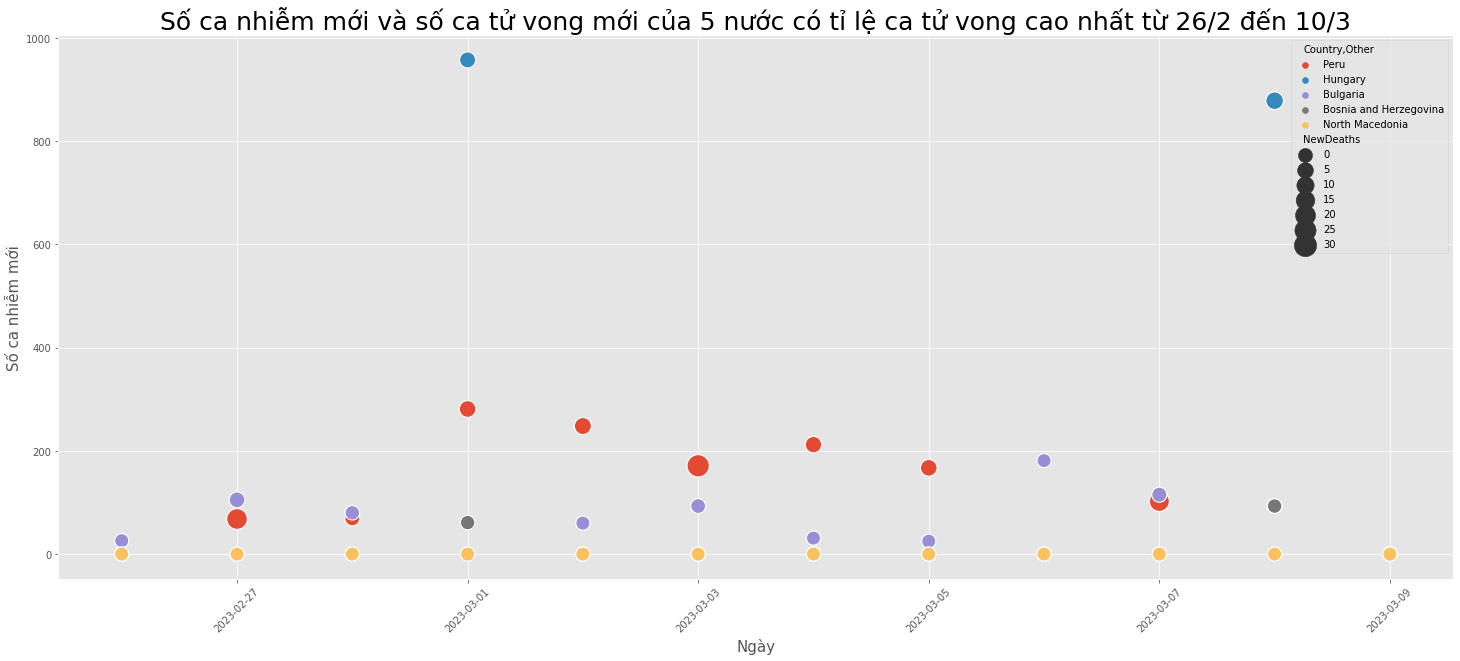

In [121]:
plt.figure(figsize=(25, 10))
sns.scatterplot(data=final_df[final_df['Country,Other'].isin(top_5_countries_death)], x='DateCollected', y="NewCases", hue="Country,Other", size="NewDeaths", sizes=(200, 500))
plt.xticks(rotation=45)
plt.title('Số ca nhiễm mới và số ca tử vong mới của 5 nước có tỉ lệ ca tử vong cao nhất từ 26/2 đến 10/3', size=25)
plt.ylabel('Số ca nhiễm mới', size = 15)
plt.xlabel('Ngày', size = 15)

Ta thấy số ca nhiễm mới ở Hungary tương đối cao, nhưng số ca tử vong lại thấp hơn các nước khác. Ngược lại, Peru có số ca tử vong cao hơn các nước khác, nhưng số ca nhiễm mới lại thấp hơn các nước khác.

## Tình hình dịch bệnh Covid-19 trên 5 quốc gia có lượt thực hiện test thấp nhất (xét trên 1 triệu dân)

In [151]:
top_5_countries_least_test = final_df.sort_values('Tests/ 1M pop', ascending=True)['Country,Other'].unique()[:5]
top_5_countries_least_test_df = final_df[final_df['Country,Other'].isin(top_5_countries_least_test)].loc[:, ['NewCases', 'NewDeaths', 'NewRecovered', 'Country,Other', 'Tests/ 1M pop', "Deaths/1M pop", 'DateCollected']].reset_index(drop=True)

## Trực quan số ca test của 5 quốc gia này

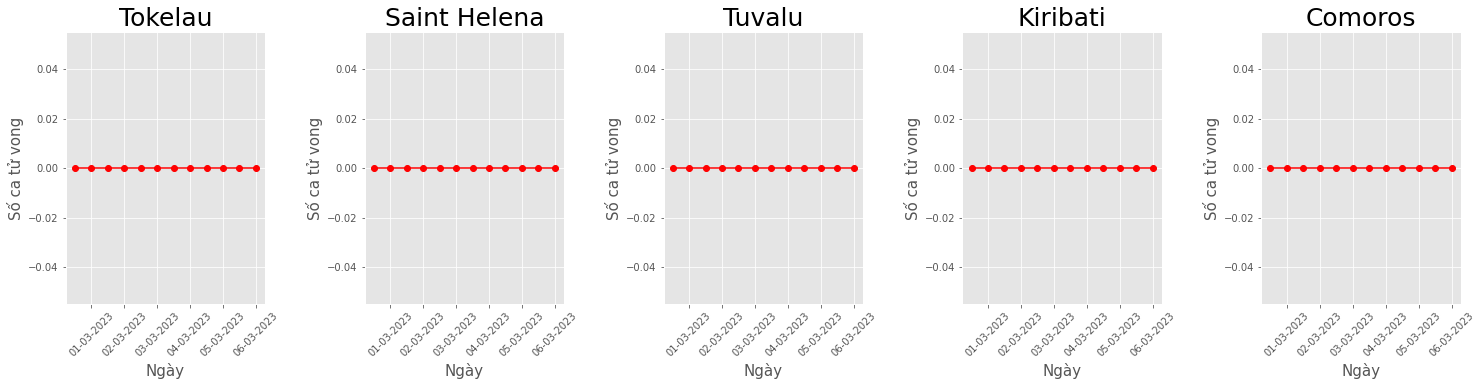

In [149]:
#visualize Tests/ 1M pop of top 5 countries with least tests
#visual each country with a subplot bar chart

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.set_figheight(5)
fig.set_figwidth(25)

for i, country in enumerate(top_5_countries_least_test):
    ax = axes[i]
    ax.plot(top_5_countries_least_test_df[top_5_countries_least_test_df['Country,Other'] == country].groupby('DateCollected')['Tests/ 1M pop'].sum(), label='Tests/ 1M pop', marker='o', color='red')
    ax.set_title(f'{country}', size=25)
    ax.set_ylabel('Số ca tử vong', size = 15)
    ax.set_xlabel('Ngày', size = 15)
    ax.set_xticklabels(days, rotation=45)



Số ca thực hiện test của 5 quốc gia đều bằng 0, do đó ta cùng tìm hiểu thêm các chỉ số khác như tỉ lệ ca nhiễm mới, tỉ lệ ca tử vong để có thể đánh giá được tình hình dịch bệnh của các quốc gia này.

## a. Tổng số ca ca nhiễm mới

Text(0, 0.5, 'Số ca nhiễm mới')

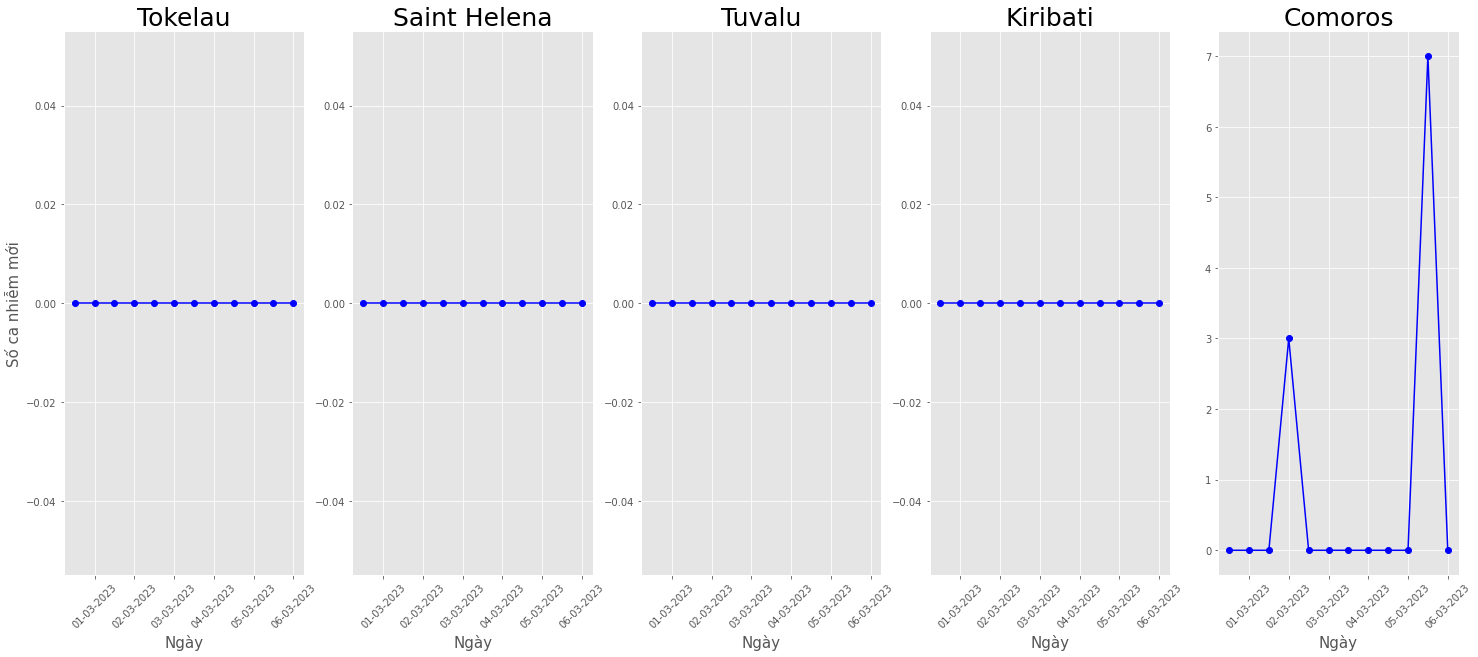

In [133]:

ax, axes = plt.subplots(1, 5, figsize=(25, 10))
for i, country in enumerate(top_5_countries_least_test):
    ax = axes[i]
    ax.plot(top_5_countries_least_test_df[top_5_countries_least_test_df['Country,Other'] == country].groupby('DateCollected')['NewCases'].sum(), label='NewDeaths', marker='o', color='blue')
    ax.set_title(f'{country}', size=25)
    ax.set_xlabel('Ngày', size = 15)
    ax.set_xticklabels(days, rotation=45)
axes[0].set_ylabel('Số ca nhiễm mới', size = 15)


Ta thấy Comoros là quốc gia có tỉ lệ ca nhiễm mới cao , tăng lên 7 ca trong ngày 8/3/2023

Trong khi các quốc gia còn lại tỉ lệ thực hiện test thấp nên không phát hiện ra ca nhiễm mới nào

## b. Tổng số ca tử vong từ ngày 26/2/2023 đến ngày 6/3/2023

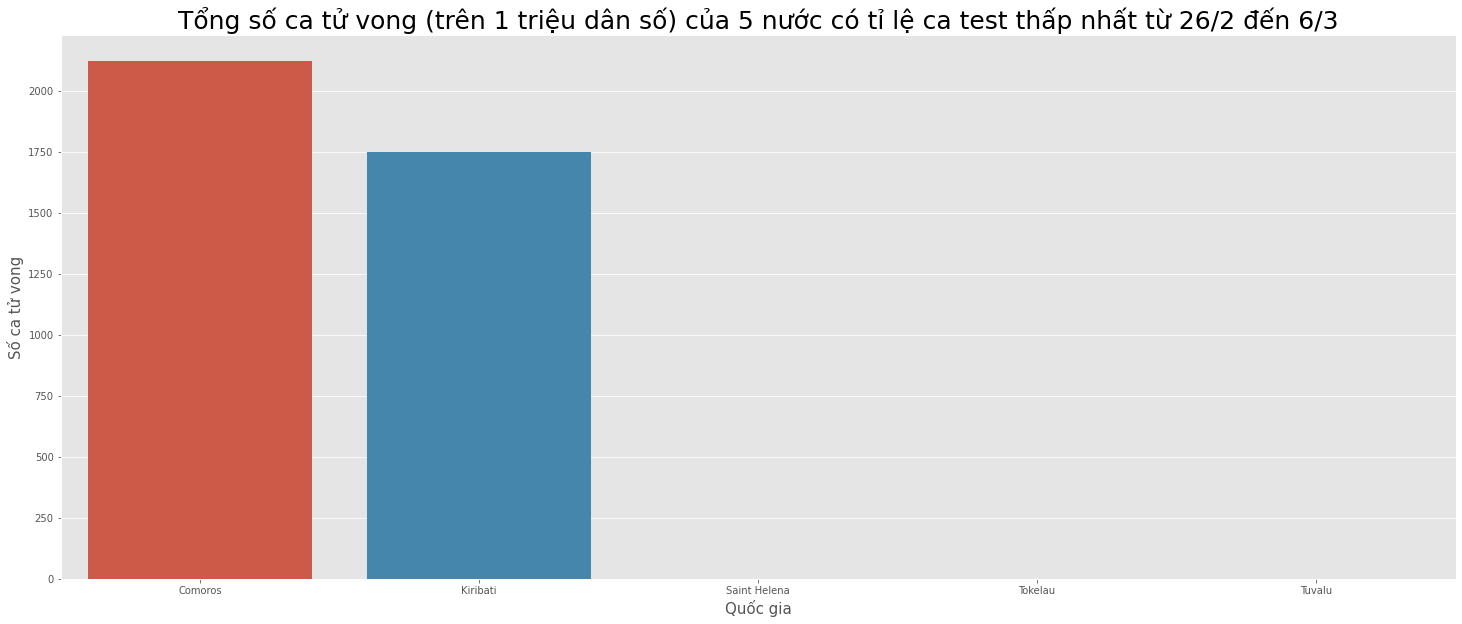

In [153]:

plt.figure(figsize=(25, 10))
sns.barplot(x=top_5_countries_least_test_df.groupby('Country,Other')['Deaths/1M pop'].sum().index, y=top_5_countries_least_test_df.groupby('Country,Other')['Deaths/1M pop'].sum().values)
plt.title('Tổng số ca tử vong (trên 1 triệu dân số) của 5 nước có tỉ lệ ca test thấp nhất từ 26/2 đến 6/3', size=25)
plt.ylabel('Số ca tử vong', size = 15)
plt.xlabel('Quốc gia', size = 15)
plt.show()


Ta thấy rằng quốc gia Comoros có tỉ lệ ca tử vong cao nhất trong 5 quốc gia có tỉ lệ thực hiện test thấp nhất.